2D Multi-bump Grid cell Continuous Attractor Neural Network (CANN)  
Translated from MATLAB to Python
**Reference**: Burak Y, Fiete IR. Accurate path integration in continuous attractor network models of grid cells. PLoS Comput Biol. 2009 Feb;5(2):e1000291. doi: 10.1371/journal.pcbi.1000291. Epub 2009 Feb 20. PMID: 19229307; PMCID: PMC2632741.  
#### Notebook Structure
1. **Trajectory Synthesis:** Defines temporal resolution, boundary constraints, and velocity dynamics to generate position and heading traces for 100 000 steps.
2. **Network Initialization:** Builds the 2D continuous attractor sheet, including center-surround synaptic kernels, FFT-based convolution tensors, and the four interleaved direction-selective neuron classes.
3. **Simulation Workflow:** Executes stabilization followed by path-integration updates, applying velocity-modulated drive, recurrent integration, rectification, and bounded rate dynamics; population activity snapshots are stored in `r_all`.
4. **Visualization Assets:** Provides interactive animations for the stabilization and path-integration phases, along with trajectory overlays, single-neuron responses, and GIF export utilities.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from datetime import datetime

### Generate random trajectories

Generate random temporal velocity and turns in heading directions

In [2]:
dt=0.5       # ms, time step
demo_short = False  # whether to run a short demo

In [3]:
enclosureRadius = 2 * 1000.0  # two meters in original units
accelerationLimit = 0.2  # cm/ms^2 in original units
temp_vel_uplim = 0.25  # max velocity 2.5 mm/ms in original units
temp_velocity = np.random.rand() / 0.2  # initial velocity 0-0.5 mm/ms
if demo_short:
    max_steps = 20000
else:
    max_steps = 100000

# 包含二维坐标和头部方向
position_x = np.zeros(max_steps)
position_y = np.zeros(max_steps)
headDirection = np.zeros(max_steps)

position_x[0] = 0.0
position_y[0] = 0.0
headDirection[0] = np.random.rand() * 2.0 * np.pi
velocity = np.zeros((max_steps,2))
for i in range(1, max_steps):

    # max acceleration ~ .1 cm/ms^2 in original (scaled)  模拟加速度限制
    temp_rand = np.clip(np.random.normal(0.0, 0.05), -1*accelerationLimit, accelerationLimit)
    # update temperal velocity (0-2.5 mm/ms = 2.5 m/s) 转单位为m/s
    temp_velocity = np.clip(temp_velocity/10 + temp_rand, 0.0, temp_vel_uplim) * 10.0

    # random left or right if about to exit enclosure
    leftOrRight = -1 if np.round(np.random.rand()) == 0 else 1

    # ensure within bounds
    while np.sqrt((position_x[i-1] + np.cos(headDirection[i-1]) * temp_velocity)**2 +
                    (position_y[i-1] + np.sin(headDirection[i-1]) * temp_velocity)**2) > enclosureRadius:
        headDirection[i-1] = headDirection[i-1] + leftOrRight * np.pi / 100.0

    # update position
    position_x[i] = position_x[i-1] + np.cos(headDirection[i-1]) * temp_velocity
    position_y[i] = position_y[i-1] + np.sin(headDirection[i-1]) * temp_velocity

    # save current velocity
    velocity[i,0] = np.cos(headDirection[i-1]) * temp_velocity
    velocity[i,1] = np.sin(headDirection[i-1]) * temp_velocity

    # update headDirection with small random turn (same scaling as MATLAB)
    headDirection[i] = (headDirection[i-1] + (np.random.rand() - 0.5) / 5.0 * np.pi / 2.0) % (2.0 * np.pi)

sampling_length = len(position_x)

# Compute headDirection from positions (recompute to be consistent with MATLAB)
headDirection = np.zeros(sampling_length)

for i in range(sampling_length - 1):
    headDirection[i] = np.mod(np.arctan2((position_y[i+1] - position_y[i]), (position_x[i+1] - position_x[i])), 2.0*np.pi)
headDirection[-1] = headDirection[-2]

print("Trajectory data generated.")
print(f'total time length: {sampling_length}, dt: {dt} ms, total time: {sampling_length*dt/1000} s')
print(f'velocity range: {np.min(np.linalg.norm(velocity, axis=1))} to {np.round(np.max(np.linalg.norm(velocity, axis=1)), 3)} mm/ms')

Trajectory data generated.
total time length: 100000, dt: 0.5 ms, total time: 50.0 s
velocity range: 0.0 to 2.5 mm/ms


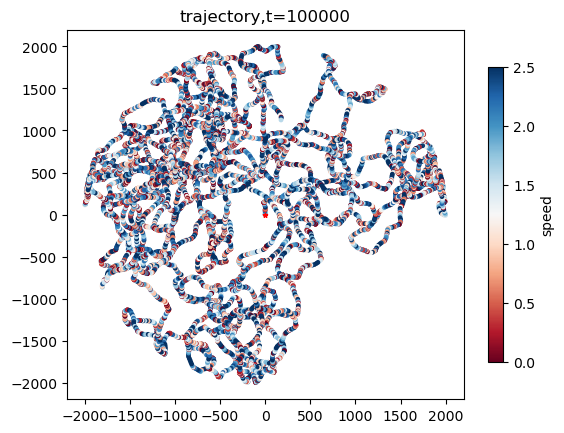

In [4]:
# visualize the tranjectory
plt.figure()
plt.title(f"trajectory,t={max_steps}")
speed = np.linalg.norm(velocity, axis=1)
a1 = plt.scatter(position_x[::10], position_y[::10],c=speed[::10],cmap='RdBu', s = 6)
plt.scatter([position_x[0]],[position_y[0]],marker='*',color='r',s=10)
plt.colorbar(a1, shrink=0.8, label='speed')

### 2D Continuous attractor Network Construction
+ Initialize network variables
+ Generate 4 subsets of direction tuning neurons
+ Arrange four categories of direction tuning cells onto the neural sheet

#### Equations of kernel

 Weight kernel definition

$$x \in \left\{-\frac{n}{2}, \ldots, \frac{n}{2}-1\right\}, \qquad \bar{x} = \sqrt{\beta}\,x$$
$$W_{ij}=W_0(\mathbf{x}_i-\mathbf{x}_j - l\hat{\mathbf{e}}_{\theta})$$

where $\mathbf{e_{\theta}}$ is a unit vector in the direction $\theta$, and $W_0$ is defined:

$$W_0(x) = a_{bar} \exp\left(-\gamma |x|^2\right) - \exp\left(-\beta |x|^2\right)$$

where substitude x with $x_{bar}=\sqrt{\beta}x$, so that  
$$W_0(x_{bar}) = a_{bar} \exp\left(-\alpha_{bar} |x_{bar}|^2\right) - \exp\left(-|x_{bar}|^2\right)$$

The first Gaussian term (scaled by $\bar{a}$ and shaped by $\bar{\alpha}$) provides local excitation, while the broader negative Gaussian supplies surround inhibition, yielding the center-surround synaptic weight kernel used in the network.

In [5]:
# ---- Network parameters ----
# neural sheet parameters
n=2**7
tau=5

lambd=13.0
alphabar=1.05
abar=1.0
wtphase=2

# ---- Derived constants ----
beta = 3.0 / (lambd**2)   # from Equation (3) in original code
alpha = 0.1        # velocity gain from Equation (4)


In [6]:
# ---- Network parameters ----
# neural sheet parameters
big = 2 * n
dim = n // 2   # square neural sheet with shape of (n/2 * n/2) 

# initialize population activity (n x n)
r = np.zeros((n, n), dtype=float)
rfield = r.copy()
s = r.copy()

# spikes as a list of sparse-like arrays (booleans) -- keep small for demo
spikes = [np.zeros((n, n), dtype=bool) for _ in range(sampling_length)]

# single neuron tracking (center neuron)
sNeuronResponse = np.zeros(sampling_length,dtype='int32')
sNeuron = (n//2, n//2)   # single neuron idx for plotting activity

# envelope and filter parameters
x = np.arange(-n//2, n//2)   # x坐标
lx = len(x)
xbar = np.sqrt(beta) * x     # rescale x
# ---- Initialize synaptic weight matrices ----
# center-surround difference of Gaussians (Equation 3)
X1 = np.tile(xbar.reshape((lx,1)), (1,lx))  # np.tile() repeat 1 time at row directions and 1x at column directions
X2 = X1.T
filt = abar * np.exp(-alphabar * (X1**2 + X2**2)) - np.exp(-1.0 * (X1**2 + X2**2))   # weight dep. on the sum of dist. at X dir.and .at Y dir.
# filt.shape = 128 * 128
# plt.imshow(filt)

In [7]:

# create shifted versions of filt (circshift)
frshift = np.roll(filt, shift=wtphase, axis=1)
flshift = np.roll(filt, shift=-wtphase, axis=1)
fdshift = np.roll(filt, shift=wtphase, axis=0)
fushift = np.roll(filt, shift=-wtphase, axis=0)

# fft of shifted filters on a bigger grid (non-periodic usage)
ftu = np.fft.fft2(fushift, s=(big, big))
ftd = np.fft.fft2(fdshift, s=(big, big))
ftl = np.fft.fft2(flshift, s=(big, big))
ftr = np.fft.fft2(frshift, s=(big, big))

# small (periodic) versions for later use (fft of fftshifted filters)
ftu_small = np.fft.fft2(np.fft.fftshift(fushift))
ftd_small = np.fft.fft2(np.fft.fftshift(fdshift))
ftl_small = np.fft.fft2(np.fft.fftshift(flshift))
ftr_small = np.fft.fft2(np.fft.fftshift(frshift))

In [8]:
# fixed arrangement with 4 different categories in (2x2) block
# block matrices for neuron preferred directions (2x2 blocks repeated)
typeL = np.tile(np.array([[1,0],[0,0]]), (dim, dim))
typeR = np.tile(np.array([[0,0],[0,1]]), (dim, dim))
typeU = np.tile(np.array([[0,1],[0,0]]), (dim, dim))
typeD = np.tile(np.array([[0,0],[1,0]]), (dim, dim))


In [9]:
# Visualization of arrangement of velocity-tuned neurons
# def visualize_four_subsets(typeD, typeU, typeL, typeR):
#     slice_n = 20
#     plt.figure()
#     def create_binary_cmap(color):
#         """创建二值颜色映射"""
#         colors = [(0, 0, 0, 0), color]  # 0:透明，1:指定颜色
#         return ListedColormap(colors)

#     # 定义颜色
#     cmap_D = create_binary_cmap((1, 0, 0, 1))  # 红色
#     cmap_U = create_binary_cmap((0, 1, 0, 1))  # 绿色
#     cmap_L = create_binary_cmap((0, 0, 1, 1))  # 蓝色
#     cmap_R = create_binary_cmap((0.5, 0, 0.5, 1))  # 紫色
#     plt.imshow(typeD[:slice_n,:slice_n], cmap=cmap_D, vmin=0, vmax=1)
#     plt.imshow(typeU[:slice_n,:slice_n], cmap=cmap_U, vmin=0, vmax=1)
#     plt.imshow(typeL[:slice_n,:slice_n], cmap=cmap_L, vmin=0, vmax=1)
#     plt.imshow(typeR[:slice_n,:slice_n], cmap=cmap_R, vmin=0, vmax=1)
# visualize_four_subsets(typeD, typeU, typeL, typeR)

###  Simulation


##### Equations
The dynamics of rate-based neurons in the 2D continuous attractor network are governed by the following equations:
    $$\tau\cfrac{\mathrm{d}s_i}{dt}+s_i=f[\sum_jW_{ij}s_j+B_i]$$
where the feedforward input$B_i$is given by
    $$B_i=A(x_i)(1+\alpha \hat{\mathbf{e}}_{\theta}\cdot\mathbf{v})$$  
    $A(x_i)$ is envelope functions that attenuates activity near the edges of the neural sheet, $\alpha$ is a velocity scaling factor, $\hat{\mathbf{e}}_{\theta}$ is a unit vector in the direction of head direction $\theta$, and $\mathbf{v}$ is the animal's velocity vector.
##### Implementation steps:
- **Directional drive with velocity modulation**
    $$
    r_{\text{field}}(\mathbf{x}, t)=v_{\text{env}}(\mathbf{x})\!\left[(1+\alpha v_t \cos\theta_t)\,T_R+(1-\alpha v_t \cos\theta_t)\,T_L+(1+\alpha v_t \sin\theta_t)\,T_U+(1-\alpha v_t \sin\theta_t)\,T_D\right]
    $$
    where $v_t=\|\mathbf{v}(t)\|$, $\theta_t=\text{headDirection}(t)$, $v_{\text{env}}$ is the envelope, and $T_{\{R,L,U,D\}}$ pick the corresponding tuned sub-populations.

- **Recurrent synaptic integration (center–surround kernel)**
    $$
    \tilde r(\mathbf{x},t)=\sum_{d\in\{R,L,U,D\}}\left[(r(\mathbf{x},t)\odot T_d)*W_d\right],\qquad r_{\text{field}}(\mathbf{x},t)\leftarrow r_{\text{field}}(\mathbf{x},t)+\tilde r(\mathbf{x},t)
    $$

- **Threshold-linear firing**
    $$
    f_r(\mathbf{x},t)=\max\bigl(0,\,r_{\text{field}}(\mathbf{x},t)\bigr)
    $$

- **First-order neural dynamics with saturation**
    $$
    r(\mathbf{x},t+\Delta t)=\min\!\left(10,\;r(\mathbf{x},t)+\frac{\Delta t}{\tau}\left(5\,f_r(\mathbf{x},t)-r(\mathbf{x},t)\right)\right)
    $$

In [10]:
# ---- BEGIN SIMULATION (aperiodic boundary to form network) ----

# initial movement conditions
theta_v = np.pi / 5.0
left = -np.sin(theta_v)
right = np.sin(theta_v)
up = -np.cos(theta_v)
down = np.cos(theta_v)
vel = 0.0

# envelope function (Equation 5)  处理边缘的包络函数
venvelope = np.exp(-4.0 * ( (x.reshape((n,1))**2) + (x.reshape((1,n))**2) ) / ((n/2.0)**2))
stablization_iter = 2000
max_iter = min(2000,max_steps)
all_steps = stablization_iter + max_iter
# save population activity
r_all = np.zeros((all_steps, n, n), dtype=float)
interval = 100
r = np.zeros((n,n))
for it in range(stablization_iter):
    if it == 800:
        # switch to periodic convolution after initial stabilization
        venvelope = np.ones((n,n))

    # Break envelope into directional components (Equation 4 equivalent)
    rfield = venvelope * ((1 + vel*right) * typeR + (1 + vel*left) * typeL + (1 + vel*up) * typeU + (1 + vel*down) * typeD)

    # Convolution via FFT on big grid
    fft_rR = np.fft.fft2(r * typeR, s=(big, big))
    fft_rL = np.fft.fft2(r * typeL, s=(big, big))
    fft_rD = np.fft.fft2(r * typeD, s=(big, big))
    fft_rU = np.fft.fft2(r * typeU, s=(big, big))

    convolution = np.real(np.fft.ifft2(fft_rR * ftr + fft_rL * ftl + fft_rD * ftd + fft_rU * ftu))

    # extract center n x n block
    start = big//2 - n//2
    end = start + n
    conv_center = convolution[start:end, start:end]

    rfield = rfield + conv_center

    # Neural transfer function (threshold linear)
    fr = (rfield > 0) * rfield  # rfield:(128,128)

    # neuron dynamics (Eq. 1)
    r_old = r.copy()
    r_new = np.minimum(10.0, (dt/tau) * (5.0 * fr - r_old) + r_old)   # rnew:(128,128)
    r = r_new
    r_all[it,:,:] = r

# continue with path integration simulation
for i in range(max_iter):

    theta_v = headDirection[i]
    vel = np.linalg.norm(velocity[i,:])  # speed magnitude
    left = -np.cos(theta_v)
    right = np.cos(theta_v)
    up = -np.sin(theta_v)    
    down = np.sin(theta_v)
    # Break envelope into directional components (Equation 4 equivalent)
    rfield = venvelope * ((1 + alpha*vel*right) * typeR + 
                          (1 + alpha*vel*left) * typeL + 
                          (1 + alpha*vel*up) * typeU +
                          (1 + alpha*vel*down) * typeD)

    # Convolution via FFT 
    fft_rR = np.fft.fft2(r * typeR)
    fft_rL = np.fft.fft2(r * typeL)
    fft_rD = np.fft.fft2(r * typeD)
    fft_rU = np.fft.fft2(r * typeU)

    convolution = np.real(np.fft.ifft2(fft_rR * ftr_small + fft_rL * ftl_small + fft_rD * ftd_small + fft_rU * ftu_small))

    rfield = rfield + convolution

    # Neural transfer function (threshold linear)
    fr = (rfield > 0) * rfield  # rfield:(128,128)

    # neuron dynamics (Eq. 1)
    r_old = r.copy()
    r_new = np.minimum(10.0, (dt/tau) * (5.0 * fr - r_old) + r_old)   # rnew:(128,128)
    r = r_new
    r_all[stablization_iter+i,:,:] = r


### Visualization

In [11]:
iwatch = (n//2, n//2)   # single neuron idx for plotting activity

#### Visualize stabilization period

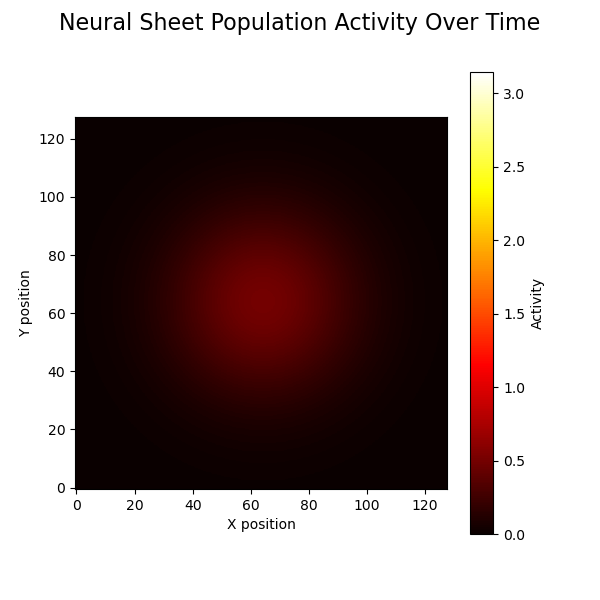

In [12]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Neural Sheet Population Activity Over Time', fontsize=16)
im = ax.imshow(
    r_all[0, :, :],
    origin='lower',
    cmap='hot',
    vmin=0,
    vmax=np.max(r_all),
    animated=False
)
# ax.set_title('Population Activity (t = 0.00 s)')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
plt.colorbar(im, ax=ax, label='Activity')


# redefine update to only update the heatmap
def update2(frame):
    im.set_array(r_all[frame, :, :])
    im.set_clim(0, np.max(r_all))
    t_ms = frame * dt
    title = f'(t = {t_ms:.2f} ms)'
    ax.set_title(title)
    return (im,)

frame_step = 50
# create new animation (replace previous)
ani = animation.FuncAnimation(
    fig,
    update2,
    frames=range(0, all_steps, frame_step),
    interval=5,
    blit=False,
    repeat=True
)

plt.show()

In [13]:
ani.event_source.stop()
%matplotlib inline

#### Visualize Path integration

In [14]:
r_pi = r_all[stablization_iter:,:,:]
threshold = 0.05

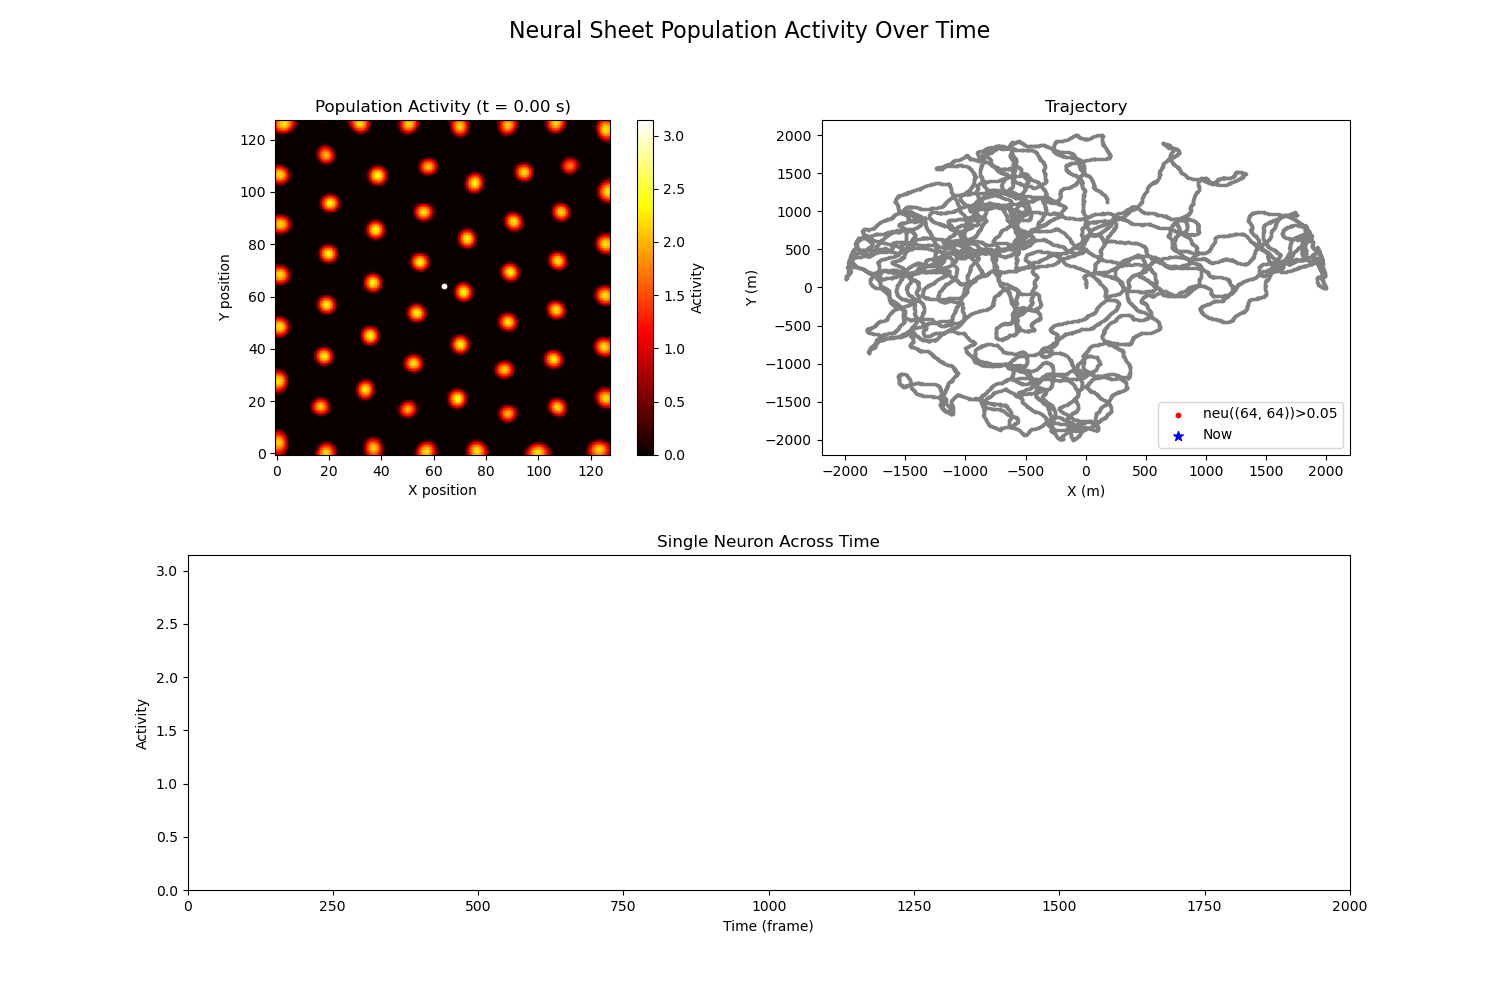

In [15]:
%matplotlib widget
import matplotlib.gridspec as gridspec

fig1 = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, figure=fig1, hspace=0.3)
ax1 = fig1.add_subplot(gs[0, 0])
ax2 = fig1.add_subplot(gs[0, 1])
ax3 = fig1.add_subplot(gs[1, :])

fig1.suptitle('Neural Sheet Population Activity Over Time', fontsize=16)

# --- 左上图：neural sheet population ---
im = ax1.imshow(
    r_pi[0, :, :],
    origin='lower',
    cmap='hot',
    vmin=0,
    vmax=np.max(r_pi),
    animated=False
)
ax1.scatter(iwatch[0], iwatch[1], marker='o', color='white', s=10, label='neu')
ax1.set_title('Population Activity (t = 0.00 s)')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
plt.colorbar(im, ax=ax1, label='Activity')

# --- 右上图：trajectory ---
ax2.scatter(position_x[:], position_y[:],
            color='grey', alpha=0.3, s=2)
scatter1 = ax2.scatter([], [], color='red', s=10, label=f'neu({iwatch[0],iwatch[1]})>{threshold}')
scatter2 = ax2.scatter([], [], marker='*', color='blue', s=50, label='Now')
ax2.set_title('Trajectory')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()

# --- 下图：single neuron across time ---
line, = ax3.plot([], [], lw=2, color='red')
ax3.set_title('Single Neuron Across Time')
ax3.set_xlabel('Time (frame)')
ax3.set_ylabel('Activity')
ax3.set_xlim(0, r_pi.shape[0])
ax3.set_ylim(0, np.max(r_pi))

def update(frame):
    actual_frame = frame + stablization_iter
    
    # Update heatmap
    vmax = np.max(r_pi[frame, :, :])
    im.set_array(r_pi[frame, :, :])
    im.set_clim(0, vmax)
    t_ms = actual_frame * dt
    ax1.set_title(f'Population Activity (t = {t_ms:.2f} ms)')

    # Update trajectory
    active_seg_x = position_x[:frame][r_pi[:frame, iwatch[0], iwatch[1]] > threshold]
    active_seg_y = position_y[:frame][r_pi[:frame, iwatch[0], iwatch[1]] > threshold]
    if len(active_seg_x) > 0:
        scatter1.set_offsets(np.column_stack([active_seg_x, active_seg_y]))
    else:
        scatter1.set_offsets(np.empty((0, 2)))
    scatter2.set_offsets([[position_x[frame], position_y[frame]]])

    # Update single neuron time series
    single_ri = r_pi[:frame, iwatch[0], iwatch[1]]
    line.set_data(range(len(single_ri)), single_ri)

    return im, scatter1, scatter2, line

max_display_frames = r_pi.shape[0]
frame_step = 10
ani = animation.FuncAnimation(
    fig1,
    update,
    frames=range(0, min(max_display_frames, 20000), frame_step),
    interval=50,
    blit=False,
    repeat=True
)

plt.show()


In [16]:
ani.event_source.stop()
%matplotlib inline

In [29]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, 'Fiete2009_2D_demo'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

Saving animation...
d:\prob_learning\grid_cell\202601_Loop model\visualization
Animation saved
